# Create files with additionally processed female behavioral variables

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import signal
import sys

from disp import plot_b, set_plot

NTR = 276
FPS = 30.03
DT = 1/FPS
SONG_FILE = 'data/simple/c_song_f_behav.csv'
SAVE_DIR = 'data/simple/behav_xtd'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [2]:
# functions for computing female behavioral variables
def fwd_mean(x, wdw):
    # forward mean
    iwdw = int(round(wdw/DT))
    h_rect = np.ones(iwdw)/iwdw
    return signal.fftconvolve(x, h_rect, mode='full')[-len(x):]

def fwd_sd(x, wdw):
    # forward std
    iwdw = int(round(wdw/DT))
    x_mat = np.nan * np.zeros((len(x), min(iwdw, len(x))))
    for cstep in range(min(iwdw, len(x))):
        x_mat[:len(x)-cstep, cstep] = x[cstep:]
    return np.nanstd(x_mat, axis=1)

In [3]:
df_load = pd.read_csv(SONG_FILE)
df_trs = [df_load[df_load['ID'] == ctr] for ctr in range(NTR)]

In [4]:
wdws = [.03, .1, .5, 1, 2, 5, 10, 30, 60, 120, 300, 600, 1200]
rsdl_wdws = [(1, 60)]

for ctr, df_tr in enumerate(df_trs):
    sys.stdout.write('.')
    tr_data = {}
    
    ffv = np.array(df_tr['FFV'])  # for vel
    fls = np.array(df_tr['FLS'])  # lat vel
    mtn = np.sqrt(ffv**2 + fls**2)  # total motion 
    
    fmfv = np.array(df_tr['FMFV'])  # for vel twd M
    fmls = np.array(df_tr['FMLS'])  # for vel twd M
    
    # compute forward means
    for wdw in wdws:
        tr_data[f'FFV_MN_{wdw}'] = fwd_mean(ffv, wdw)
        tr_data[f'FLS_MN_{wdw}'] = fwd_mean(fls, wdw)
        tr_data[f'MTN_MN_{wdw}'] = fwd_mean(mtn, wdw)
        tr_data[f'FMFV_MN_{wdw}'] = fwd_mean(fmfv, wdw)
        tr_data[f'FMLS_MN_{wdw}'] = fwd_mean(fmls, wdw)
        
    # compute forward stds
    for wdw in wdws[1:]:
        tr_data[f'FFV_SD_{wdw}'] = fwd_sd(ffv, wdw)
        tr_data[f'FLS_SD_{wdw}'] = fwd_sd(fls, wdw)
        tr_data[f'MTN_SD_{wdw}'] = fwd_sd(mtn, wdw)
        tr_data[f'FMFV_SD_{wdw}'] = fwd_sd(fmfv, wdw)
        tr_data[f'FMLS_SD_{wdw}'] = fwd_sd(fmls, wdw)
        
    # compute residuals
    for wdw_fast, wdw_slow in rsdl_wdws:
        tr_data[f'FFV_RSDL_{wdw_fast}_{wdw_slow}'] = tr_data[f'FFV_MN_{wdw_fast}'] - tr_data[f'FFV_MN_{wdw_slow}']
        tr_data[f'FLS_RSDL_{wdw_fast}_{wdw_slow}'] = tr_data[f'FLS_MN_{wdw_fast}'] - tr_data[f'FLS_MN_{wdw_slow}']
        tr_data[f'MTN_RSDL_{wdw_fast}_{wdw_slow}'] = tr_data[f'MTN_MN_{wdw_fast}'] - tr_data[f'MTN_MN_{wdw_slow}']
        tr_data[f'FMFV_RSDL_{wdw_fast}_{wdw_slow}'] = tr_data[f'FMFV_MN_{wdw_fast}'] - tr_data[f'FMFV_MN_{wdw_slow}']
        tr_data[f'FMLS_RSDL_{wdw_fast}_{wdw_slow}'] = tr_data[f'FMLS_MN_{wdw_fast}'] - tr_data[f'FMLS_MN_{wdw_slow}']

    columns = ['ID', 'FRAME', 'T'] + list(sorted(tr_data.keys()))
    tr_data['ID'] = df_tr['ID']
    tr_data['FRAME'] = df_tr['FRAME']
    tr_data['T'] = df_tr['T']
    
    df_xtd = pd.DataFrame(columns=columns, data=tr_data)
    
    df_xtd.to_csv(os.path.join(SAVE_DIR, f'behav_xtd_tr_{ctr}.csv'), index=False)

....................................................................................................................................................................................................................................................................................

# Plot example trials and smoothed variables

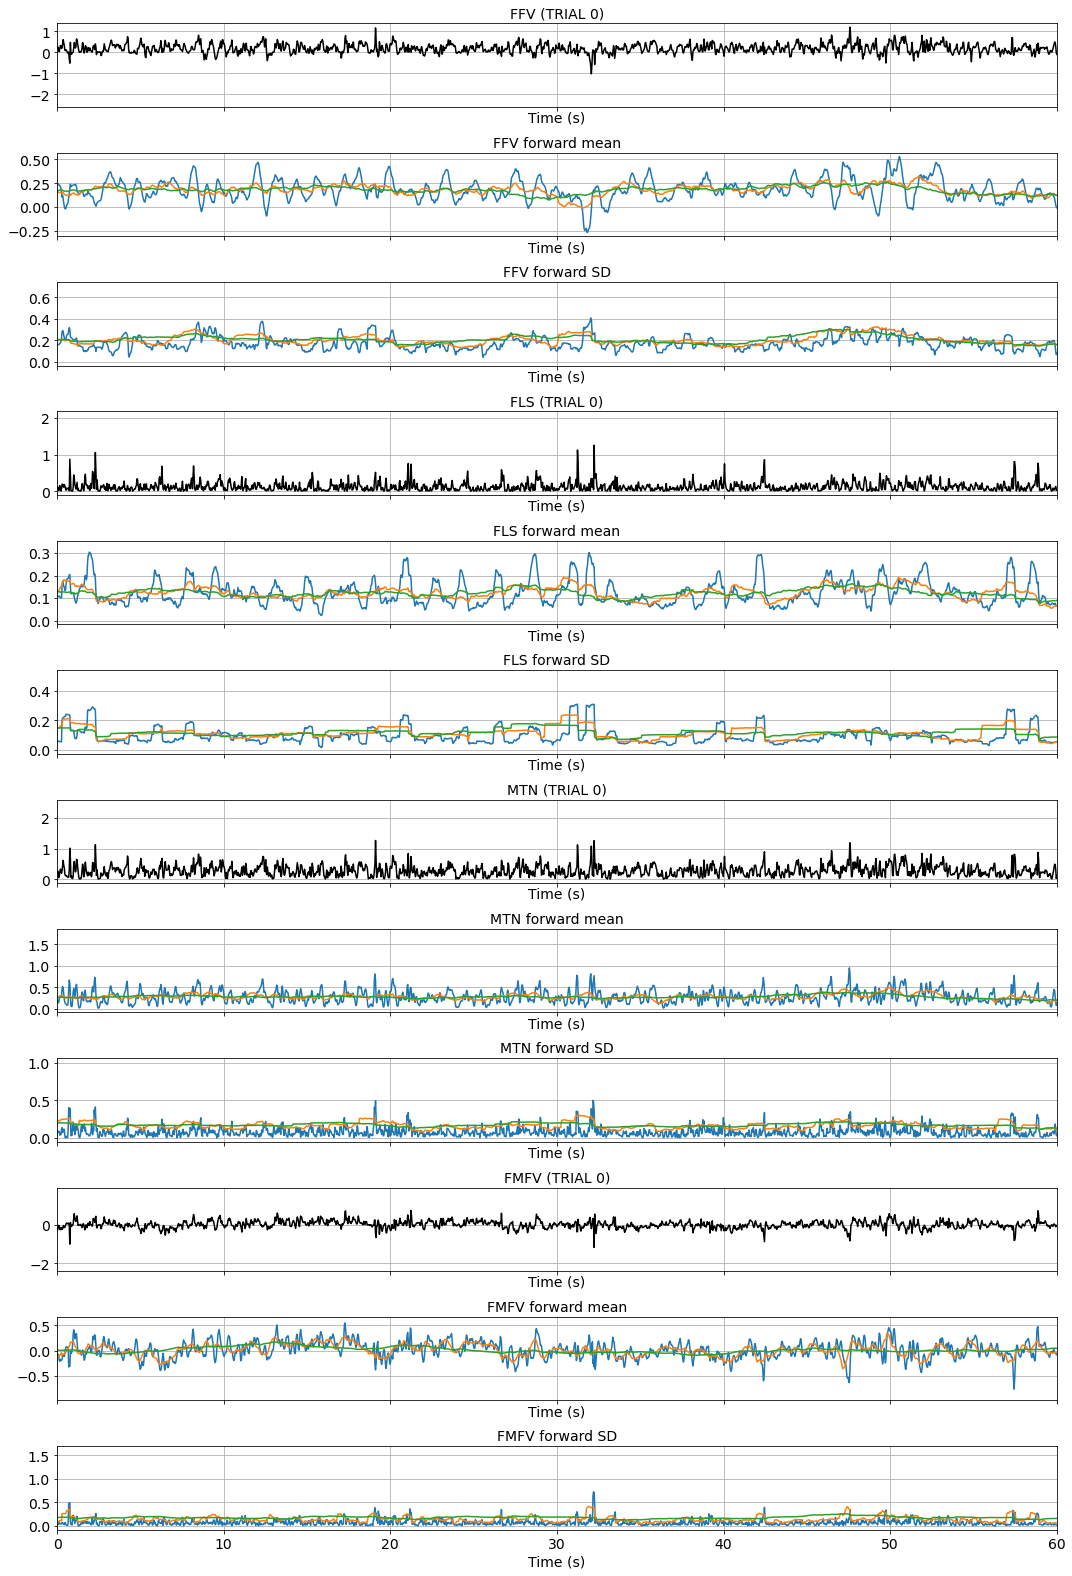

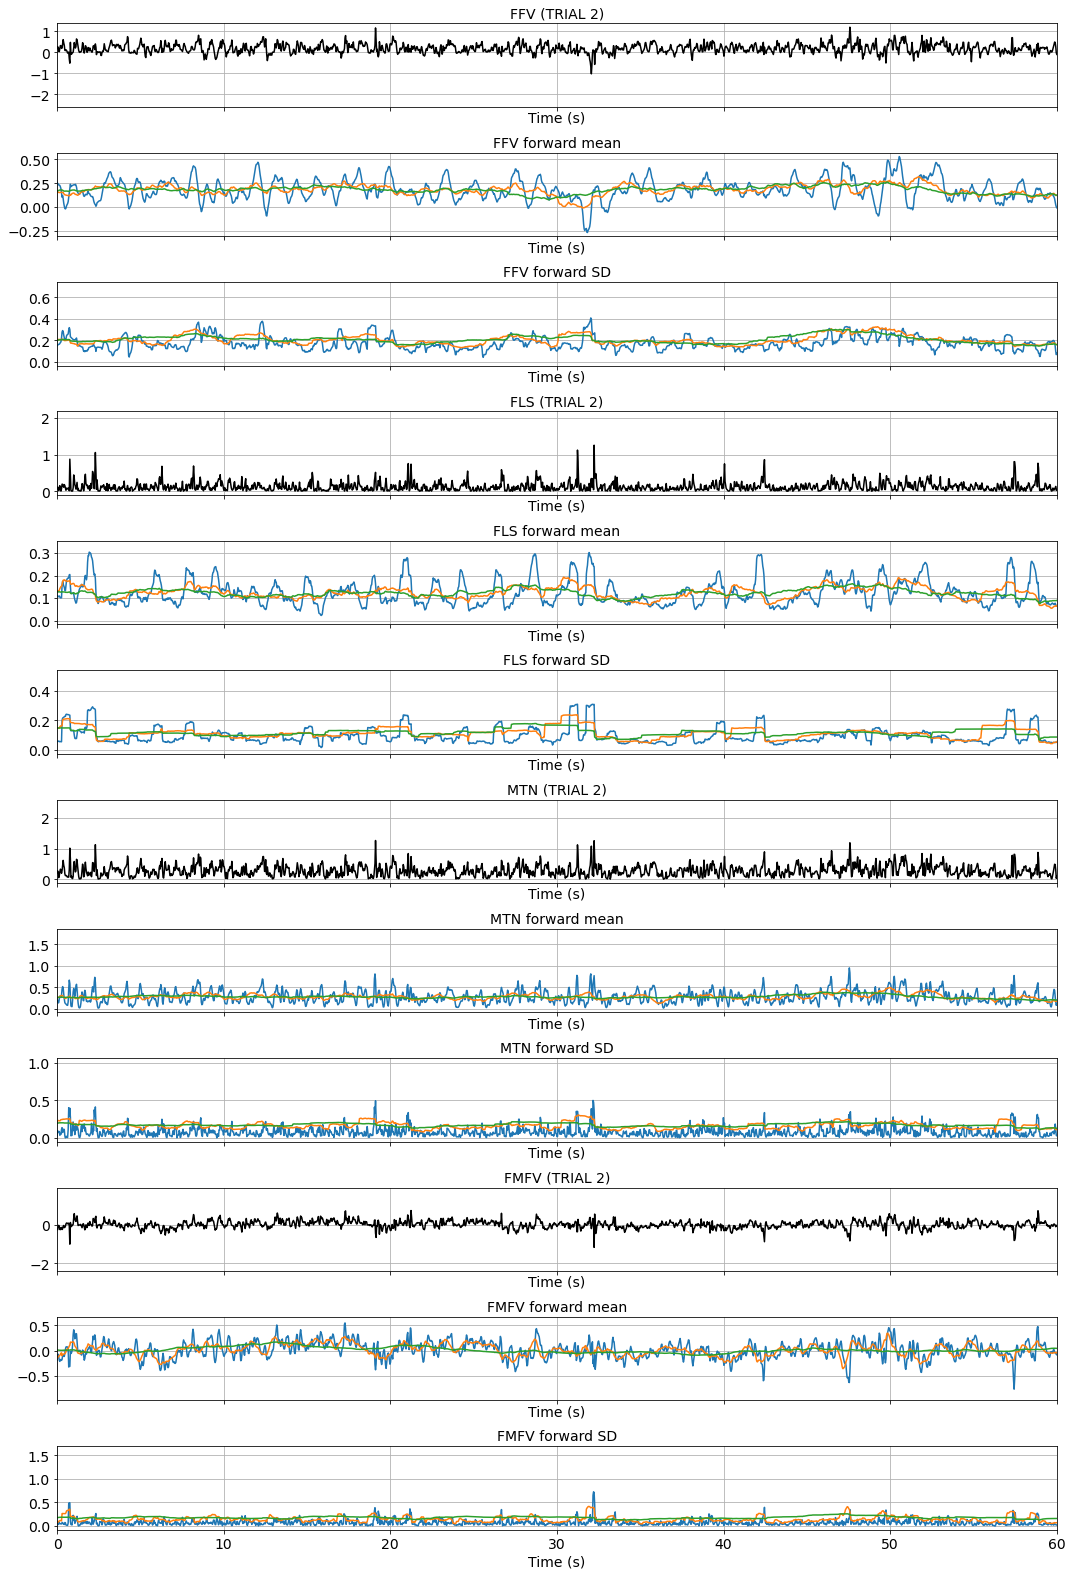

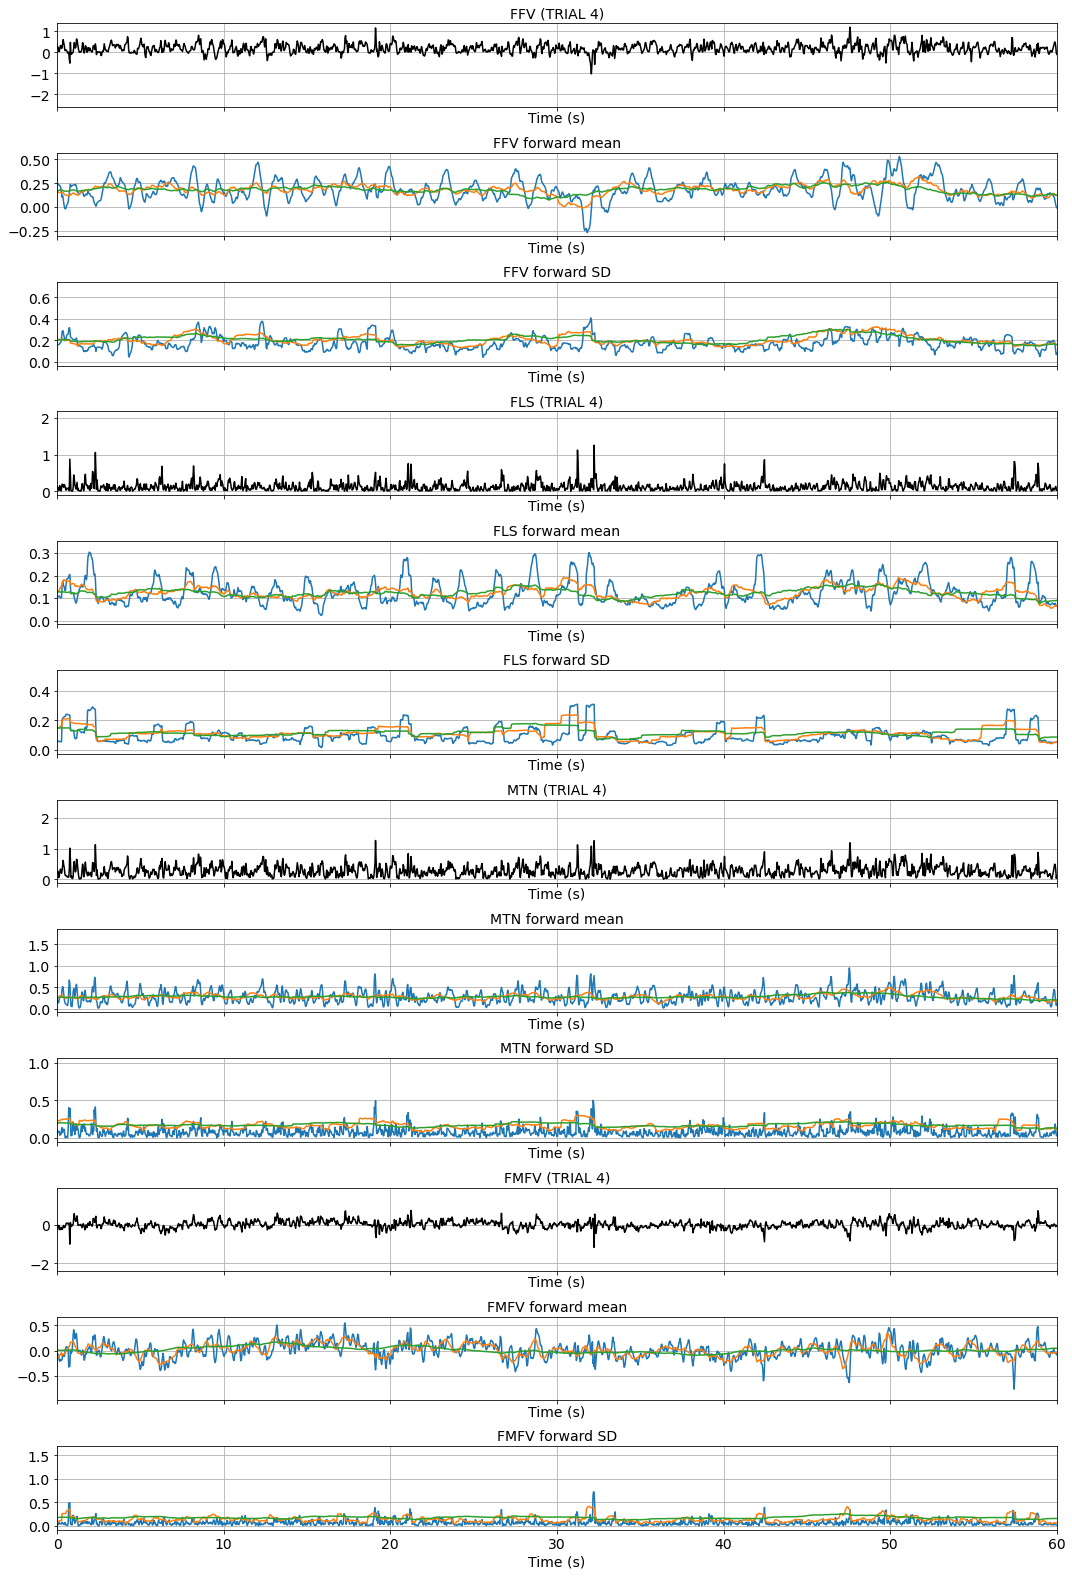

In [5]:
IXPL = [0, 2, 4]

for ixpl in IXPL:
    df_xtd = pd.read_csv(os.path.join(SAVE_DIR, f'behav_xtd_tr_{ctr}.csv'))
    
    fig, axs = plt.subplots(12, 1, figsize=(15, 22), tight_layout=True, sharex=True)
    
    axs[0].plot(df_xtd['T'], df_xtd['FFV_MN_0.03'], c='k')
    axs[0].set_title(f'FFV (TRIAL {ixpl})')
    for wdw in [.5, 2, 5]:
        axs[1].plot(df_xtd['T'], df_xtd[f'FFV_MN_{wdw}'])
        axs[2].plot(df_xtd['T'], df_xtd[f'FFV_SD_{wdw}'])
        
    axs[1].set_title('FFV forward mean')
    axs[2].set_title('FFV forward SD')
    
    axs[3].plot(df_xtd['T'], df_xtd['FLS_MN_0.03'], c='k')
    axs[3].set_title(f'FLS (TRIAL {ixpl})')
    for wdw in [.5, 2, 5]:
        axs[4].plot(df_xtd['T'], df_xtd[f'FLS_MN_{wdw}'])
        axs[5].plot(df_xtd['T'], df_xtd[f'FLS_SD_{wdw}'])
        
    axs[4].set_title('FLS forward mean')
    axs[5].set_title('FLS forward SD')
    
    axs[6].plot(df_xtd['T'], df_xtd['MTN_MN_0.03'], c='k')
    axs[6].set_title(f'MTN (TRIAL {ixpl})')
    for wdw in [.1, 1, 5]:
        axs[7].plot(df_xtd['T'], df_xtd[f'MTN_MN_{wdw}'])
        axs[8].plot(df_xtd['T'], df_xtd[f'MTN_SD_{wdw}'])
        
    axs[7].set_title('MTN forward mean')
    axs[8].set_title('MTN forward SD')
    
    axs[9].plot(df_xtd['T'], df_xtd['FMFV_MN_0.03'], c='k')
    axs[9].set_title(f'FMFV (TRIAL {ixpl})')
    for wdw in [.1, .5, 5]:
        axs[10].plot(df_xtd['T'], df_xtd[f'FMFV_MN_{wdw}'])
        axs[11].plot(df_xtd['T'], df_xtd[f'FMFV_SD_{wdw}'])
        
    axs[10].set_title('FMFV forward mean')
    axs[11].set_title('FMFV forward SD')
    
    for ax in axs:
        ax.grid()
        ax.set_xlim(0, 60)
        ax.set_xlabel('Time (s)')
        set_plot(ax, x_lim=[0, 60], x_label='Time (s)', font_size=14)